# Dichromatic MZI analysis

## Code written by Evan Klein w/ large contributions from Jesse Crawford

In [41]:
import numpy as np
import numpy.lib.recfunctions as rf
import matplotlib.pyplot as plt
from tqdm import tqdm

import astropy.units as u
from astropy.constants import c, h

import warnings
warnings.filterwarnings('ignore')

# Importing binary files and binning data 

## Variable definitions; Change/check all values in this cell for each new data set

In [50]:
folder_path = 'D:/MZI/dichromatic/di_MZI_2/' # Location of folder data is held in
file_root = 'dichromatic_MZI_' # Start of each file name in folder (Everything up till the numbers)
nfiles = 70 # Total number of data files you have (careful as usually files start counting from 0 not 1)
nbins = 420000 # Total number of bins you want data to be separated into (i.e. 70 bins over 70min means 1min per bin)

time_div_label = "min" # Time scale you want to use for plotting choose from: ms, sec, min, hrs, days

In [51]:
# Dictionary defining time scale you want to use for plotting
time_div_dict = {"ms" : 1/60, "sec" : 1, "min" : 60, "hrs" : 3600, "days" : 3600*24}
time_div_val = time_div_dict[time_div_label]

### Creating global bins from start timestamp to end timestamp

In [5]:
start_file = folder_path + file_root + str(0) + '.bin'
end_file = folder_path + file_root + str(nfiles-1) + '.bin'

# Creating bin edges to use in data aggregation
start_time = rf.structured_to_unstructured(np.fromfile(start_file, dtype = [('t','q'),('c','h')], offset=40))[1:][0][0]

end_time = rf.structured_to_unstructured(np.fromfile(end_file, dtype = [('t','q'),('c','h')], offset=40))[1:][-1][0]

hist_bins = np.linspace(start_time, end_time, nbins+1) # nbins+1 is to ensure this is bin edges not just centers
hist_bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2.0 # List of centers of bins (Shorter than bin edges list by 1)

## Iterating through files

In [6]:
hist_vals_1 = np.zeros(nbins)
hist_vals_2 = np.zeros(nbins)

for i in tqdm(range(nfiles)): # tqdm shows a progress bar
    file = folder_path + file_root + str(i) + '.bin' # Each file is its own exposure
    data_arr = rf.structured_to_unstructured(np.fromfile(file, dtype = [('t','q'),('c','h')], offset=40)) # Doing magic to get data from binary file
    data_arr = data_arr[1:] # Trimming first entry in each file as it says its from senor #104???
    
    # Seperating timestamps from single file into two lists
    timestamps_1 = data_arr[np.where(data_arr[:,1]==1)][:,0]
    timestamps_2 = data_arr[np.where(data_arr[:,1]==2)][:,0]
    
    # Aggregating timestamps into global histogram bins
    hist_vals_1 += np.histogram(timestamps_1, bins=hist_bins)[0]
    hist_vals_2 += np.histogram(timestamps_2, bins=hist_bins)[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [11:33<00:00,  9.91s/it]


### Changing timestamps into real units

In [7]:
# Converting bin values from arbitrary timestamps to real time from start of experiment
bin_centers_rt = (np.array(hist_bin_centers) - start_time)/1e12/time_div_val

In [8]:
print(bin_centers_rt[:10], '...\n')
print(f"This list contains {bin_centers_rt.size} elements")

[8.34609620e-05 2.50382886e-04 4.17304810e-04 5.84226734e-04
 7.51148658e-04 9.18070582e-04 1.08499251e-03 1.25191443e-03
 1.41883635e-03 1.58575828e-03] ...

This list contains 420000 elements


# Preliminary plot of data

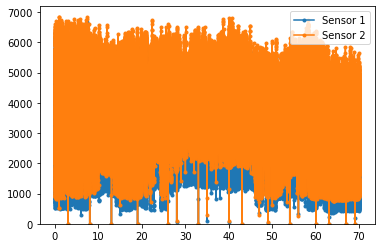

In [11]:
plt.plot(bin_centers_rt, hist_vals_1, marker='.', label='Sensor 1')
plt.plot(bin_centers_rt, hist_vals_2, marker='.', label='Sensor 2')

plt.ylim(bottom=0)

plt.legend()
plt.show()

### Zooming in and normalizing

In [20]:
# Times you want the modeling to start and end at (measured in minutes, seconds, etc.)
model_start = 0
model_end = 30

In [21]:
# Finding closest index in bin_centers_rt array to above values
start_index = np.argmin(np.abs(bin_centers_rt-model_start))
end_index = np.argmin(np.abs(bin_centers_rt-model_end))

print(start_index, end_index)

0 179724


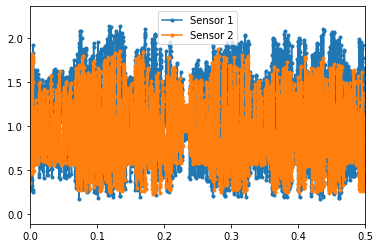

In [27]:
plt.plot(bin_centers_rt, hist_vals_1 / np.average(hist_vals_1), marker='.', label='Sensor 1')
plt.plot(bin_centers_rt, hist_vals_2 / np.average(hist_vals_2), marker='.', label='Sensor 2')

plt.xlim(0, .5)

plt.legend()
plt.show()

### Sum of both sensors (ideally should be constant)

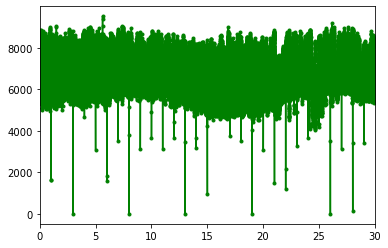

In [28]:
plt.plot(bin_centers_rt, hist_vals_1 + hist_vals_2, marker='.', color='Green')
plt.xlim(model_start, model_end)

plt.show()

# Fourier analysis

In [29]:
fft_1 = np.fft.fft(hist_vals_1[start_index:end_index])
fft_2 = np.fft.fft(hist_vals_2[start_index:end_index])
frequencies = np.fft.fftfreq(end_index-start_index, bin_centers_rt[1] - bin_centers_rt[0])

[11689372.01189264  2968996.73923358  1745260.03793744 ...
   126006.14629267   237035.14393525    59921.21245926]
[   10    12 18755 ... 86151 88385 76524]


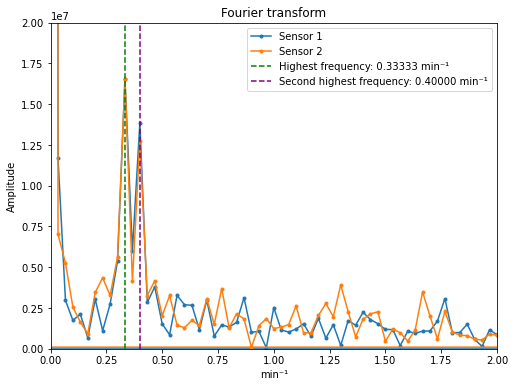

In [31]:
plt.figure(figsize = (8, 6))
plt.plot(frequencies, np.abs(fft_1), marker='.', label='Sensor 1')
plt.plot(frequencies, np.abs(fft_2), marker='.', label='Sensor 2')

plt.xlim(0, 2)
plt.ylim(0, 2e7)

# Finding two highest peaks in frequency space
fft_real = np.abs(fft_1[np.arange(1, len(fft_1)//2)]) # Midway point is Nyquist frequency and past that is negative
args_sorted = np.argsort(fft_real)[::-1]
print(fft_real)
print(args_sorted+1)
max_freq_1 = args_sorted[0] + 1 # Plus one because we cut out the 0 Hz term in our sorting
max_freq_2 = args_sorted[1] + 1

plt.axvline(x=frequencies[max_freq_1], color='Green', ls='--',
            label=f'Highest frequency: {frequencies[max_freq_1]:.5f} {time_div_label}⁻¹')
plt.axvline(x=frequencies[max_freq_2], color='Purple', ls='--',
            label=f'Second highest frequency: {frequencies[max_freq_2]:.5f} {time_div_label}⁻¹')

plt.xlabel(f"{time_div_label}⁻¹")
plt.ylabel("Amplitude")
plt.title("Fourier transform")
plt.legend()

plt.show()

## Filtering higher frequencies out

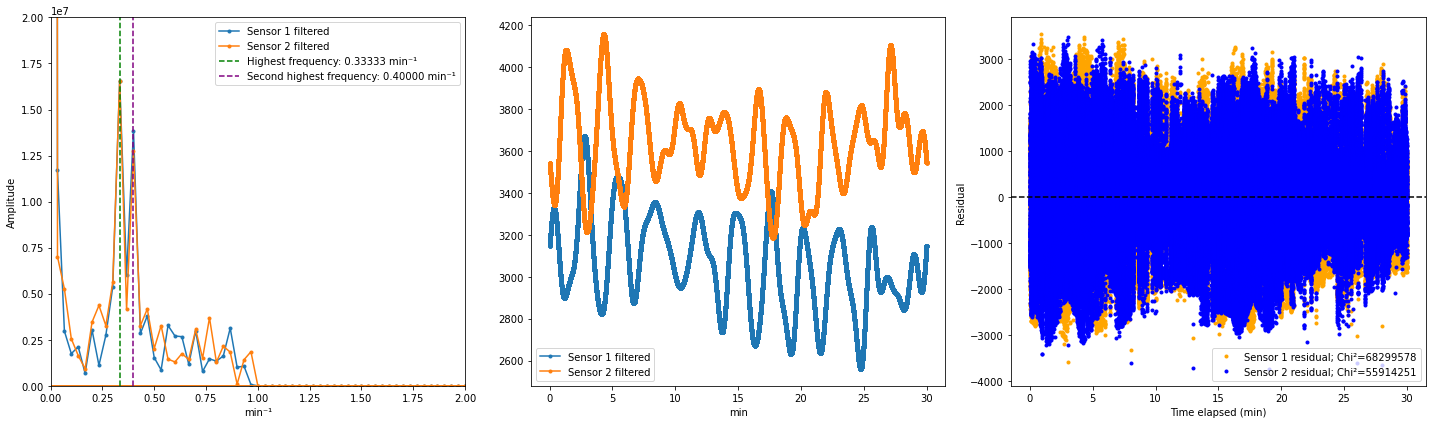

In [46]:
max_freq = 1 # Frequencies above this value will be removed from the frequency space data

# Setting all values above max freq to 0
fft_filt_1 = fft_1.copy()
fft_filt_1[np.abs(frequencies) > max_freq] = 0
fft_filt_2 = fft_2.copy()
fft_filt_2[np.abs(frequencies) > max_freq] = 0

# Turning filtered fft's into real time domain again
filtered_1 = np.fft.ifft(fft_filt_1)
filtered_2 = np.fft.ifft(fft_filt_2)

# Plotting filtered signal in time and frequency domains w/ residual
fig = plt.figure(figsize = (20, 6))

# Frequency domain
plt.subplot(131)
plt.plot(frequencies, np.abs(fft_filt_1), marker='.', label='Sensor 1 filtered')
plt.plot(frequencies, np.abs(fft_filt_2), marker='.', label='Sensor 2 filtered')

plt.axvline(x=frequencies[max_freq_1], color='Green', ls='--',
            label=f'Highest frequency: {frequencies[max_freq_1]:.5f} {time_div_label}⁻¹')
plt.axvline(x=frequencies[max_freq_2], color='Purple', ls='--',
            label=f'Second highest frequency: {frequencies[max_freq_2]:.5f} {time_div_label}⁻¹')

plt.xlim(0, max_freq+1)
plt.ylim(0, 2e7)

plt.legend()
plt.xlabel(f"{time_div_label}⁻¹")
plt.ylabel("Amplitude")

# Time domain
plt.subplot(132)
plt.plot(bin_centers_rt[start_index:end_index], filtered_1, marker='.', label='Sensor 1 filtered')
plt.plot(bin_centers_rt[start_index:end_index], filtered_2, marker='.', label='Sensor 2 filtered')

plt.legend()
plt.xlabel(f"{time_div_label}")

# Residual in time domain (Residual = Observed - Predicted)
plt.subplot(133)
residual_filtered_1 = hist_vals_1[start_index:end_index] - filtered_1[start_index:end_index]
residual_filtered_2 = hist_vals_2[start_index:end_index] - filtered_2[start_index:end_index]

# Chi^2
chi_filtered_1 = np.sum(residual_filtered_1**2 / filtered_1[start_index:end_index])
chi_filtered_2 = np.sum(residual_filtered_2**2 / filtered_2[start_index:end_index])

plt.plot(bin_centers_rt[start_index:end_index], residual_filtered_1, 
         label=f"Sensor 1 residual; Chi²={np.round(chi_filtered_1).astype(int)}", color='Orange', marker='.', ls='None')
plt.plot(bin_centers_rt[start_index:end_index], residual_filtered_2, 
         label=f"Sensor 2 residual; Chi²={np.round(chi_filtered_2).astype(int)}", color='Blue', marker='.', ls='None')
plt.axhline(y=0, color='black', linestyle='--')

#plt.xlim(0, 1)

plt.legend()

#plt.title(f"Residual plot")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel("Residual")

fig.tight_layout()
plt.show()

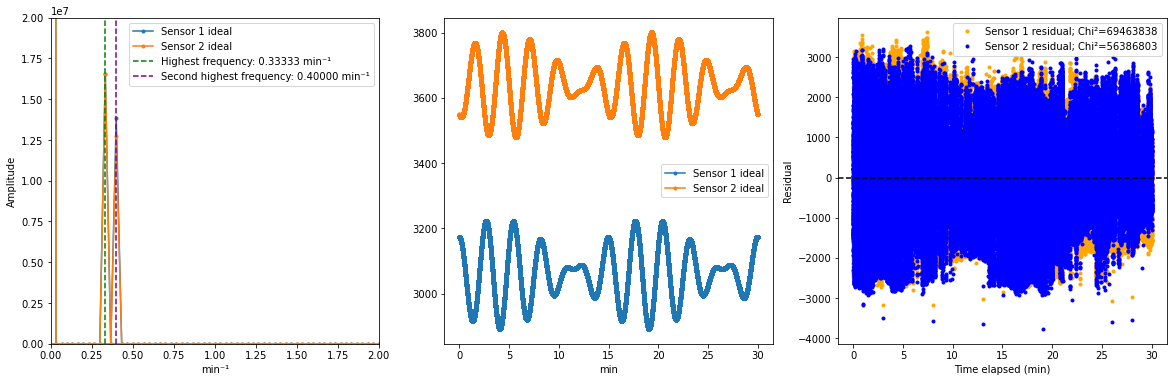

In [49]:
# Setting all frequencies besides two found before to 0
fft_ideal_1 = [0]*len(fft_1)
fft_ideal_1[0] = fft_1[0] # Constant offset value at 0 Hz
fft_ideal_1[args_sorted[0] + 1] = fft_1[args_sorted[0] + 1]
fft_ideal_1[args_sorted[1] + 1] = fft_1[args_sorted[1] + 1]

fft_ideal_2 = [0]*len(fft_2)
fft_ideal_2[0] = fft_2[0] # Constant offset value at 0 Hz
fft_ideal_2[args_sorted[0] + 1] = fft_2[args_sorted[0] + 1]
fft_ideal_2[args_sorted[1] + 1] = fft_2[args_sorted[1] + 1]

# Turning ideal fft's into real time domain again
ideal_1 = np.fft.ifft(fft_ideal_1)
ideal_2 = np.fft.ifft(fft_ideal_2)

# Plotting ideal signal in time and frequency domains
plt.figure(figsize = (20, 6))

# Frequency domain
plt.subplot(131)
plt.plot(frequencies, np.abs(fft_ideal_1), marker='.', label='Sensor 1 ideal')
plt.plot(frequencies, np.abs(fft_ideal_2), marker='.', label='Sensor 2 ideal')

plt.axvline(x=frequencies[max_freq_1], color='Green', ls='--',
            label=f'Highest frequency: {frequencies[max_freq_1]:.5f} {time_div_label}⁻¹')
plt.axvline(x=frequencies[max_freq_2], color='Purple', ls='--',
            label=f'Second highest frequency: {frequencies[max_freq_2]:.5f} {time_div_label}⁻¹')

plt.xlim(0, max_freq+1)
plt.ylim(0, 2e7)

plt.legend()
plt.xlabel(f"{time_div_label}⁻¹")
plt.ylabel("Amplitude")

# Time domain
plt.subplot(132)
plt.plot(bin_centers_rt[start_index:end_index], ideal_1, marker='.', label='Sensor 1 ideal')
plt.plot(bin_centers_rt[start_index:end_index], ideal_2, marker='.', label='Sensor 2 ideal')

plt.legend()
plt.xlabel(f"{time_div_label}")

# Residual in time domain (Residual = Observed - Predicted)
plt.subplot(133)
residual_ideal_1 = hist_vals_1[start_index:end_index] - ideal_1[start_index:end_index]
residual_ideal_2 = hist_vals_2[start_index:end_index] - ideal_2[start_index:end_index]

# Chi^2
chi_ideal_1 = np.sum(residual_ideal_1**2 / ideal_1[start_index:end_index])
chi_ideal_2 = np.sum(residual_ideal_2**2 / ideal_2[start_index:end_index])

plt.plot(bin_centers_rt[start_index:end_index], residual_ideal_1, 
         label=f"Sensor 1 residual; Chi²={np.round(chi_ideal_1).astype(int)}", color='Orange', marker='.', ls='None')
plt.plot(bin_centers_rt[start_index:end_index], residual_ideal_2, 
         label=f"Sensor 2 residual; Chi²={np.round(chi_ideal_2).astype(int)}", color='Blue', marker='.', ls='None')
plt.axhline(y=0, color='black', linestyle='--')

#plt.xlim(0, 1)

plt.legend()

#plt.title(f"Residual plot")
plt.xlabel(f"Time elapsed ({time_div_label})")
plt.ylabel("Residual")

plt.show()